pendências
- [x] Procurar sobre importância de atributos
- [x] Calcular acurácia dos modelos
- [x] Fazer previsão por liga

# Imports e carregamentos

In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.optimizers import Adam

import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data_live_engineer_filtered.csv', encoding='utf-8')

In [3]:
df.columns

Index(['homeTeam', 'awayTeam', 'shotsHome', 'shotsAway', 'blockedShotsHome',
       'blockedShotsAway', 'league', 'corners_home', 'corners_away',
       'shotsOffgoal_home', 'shotsOffgoal_away', 'shotsOngoal_home',
       'shotsOngoal_away', 'yellowcards_home', 'yellowcards_away',
       'fouls_home', 'fouls_away', 'offsides_home', 'offsides_away',
       'tackles_home', 'tackles_away', 'result', 'match_id',
       'possessiontime_away', 'possessiontime_home', 'shotsOnGoalEfficiency',
       'attackPressure', 'shotAccuracy_home', 'shotAccuracy_away',
       'possessionControl', 'passRisk', 'defensiveDiscipline',
       'defensiveEfficacy', 'defensiveAggression'],
      dtype='object')

## Preprocessamento

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pickle

# Função para separar os dados em características e variável alvo
def prepare_data(df):
    X = df.drop(columns=['result', 'homeTeam', 'awayTeam', 'match_id'])
    y = df['result']
    print("Dados separados em características (X) e variável alvo (y).")
    return X, y

# Função para criar e aplicar o transformador de colunas
def create_preprocessor(X):
    numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()
    categorical_features = ['league']

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first'), categorical_features)
        ])
    
    print("Preprocessador criado com transformações para características numéricas e categóricas.")
    return preprocessor.fit(X)

# # Preparando os dados
X, y = prepare_data(df)
preprocessor = create_preprocessor(X)
print("Preprocessador ajustado aos dados.")

# Salvando o preprocessador para uso futuro
with open('../models/preprocessor.pickle', 'wb') as f:
    pickle.dump(preprocessor, f)
    print("Preprocessador salvo em '../models/preprocessor.pickle'.")

# Dividindo os dados em conjuntos de treino e teste
X_transformed = preprocessor.transform(X)
print("Dados transformados pelo preprocessador.")

X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.20, random_state=42)
print("Dados divididos em conjuntos de treino e teste.")

Dados separados em características (X) e variável alvo (y).
Preprocessador criado com transformações para características numéricas e categóricas.
Preprocessador ajustado aos dados.
Preprocessador salvo em '../models/preprocessor.pickle'.
Dados transformados pelo preprocessador.
Dados divididos em conjuntos de treino e teste.


## Rede Neural no Keras: Treinamento e Avaliação 

### Contrução do modelo, salvamento, visualização treino e teste

Epoch 1/500
483/483 [==============================] - 3s 3ms/step - loss: 0.6891 - accuracy: 0.5340 - recall_1: 0.5368 - precision_1: 0.5340 - auc_1: 0.5499 - val_loss: 0.6848 - val_accuracy: 0.5454 - val_recall_1: 0.4893 - val_precision_1: 0.5503 - val_auc_1: 0.5670
Epoch 2/500
483/483 [==============================] - 2s 3ms/step - loss: 0.6817 - accuracy: 0.5569 - recall_1: 0.5791 - precision_1: 0.5547 - auc_1: 0.5820 - val_loss: 0.6782 - val_accuracy: 0.5652 - val_recall_1: 0.4545 - val_precision_1: 0.5828 - val_auc_1: 0.5983
Epoch 3/500
483/483 [==============================] - 2s 3ms/step - loss: 0.6741 - accuracy: 0.5707 - recall_1: 0.5932 - precision_1: 0.5678 - auc_1: 0.6042 - val_loss: 0.6695 - val_accuracy: 0.5789 - val_recall_1: 0.4990 - val_precision_1: 0.5930 - val_auc_1: 0.6195
Epoch 4/500
483/483 [==============================] - 1s 3ms/step - loss: 0.6638 - accuracy: 0.5885 - recall_1: 0.6044 - precision_1: 0.5860 - auc_1: 0.6303 - val_loss: 0.6587 - val_accuracy: 

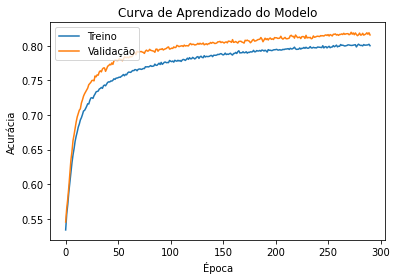

In [10]:
from sklearn.metrics import roc_auc_score
from keras.regularizers import l2, l1_l2
import tensorflow as tf  # Import the l2 regularizer
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

# , kernel_regularizer=l2(0.00005))) 

# classes = np.unique(y_train)
# weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
# class_weights = dict(zip(classes, weights))

# Criação do modelo com possivelmente mais capacidade
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dropout(0.25))  # Ajuste fino do dropout
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.15))  # Ajuste fino do dropout
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Otimizador com taxa de aprendizado inicial mais alta 
optimizer = Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', tf.metrics.Recall(), tf.metrics.Precision(), tf.metrics.AUC()])

# Ajuste no callback de EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Treinamento do modelo com pesos das classes se o conjunto for desbalanceado
history = model.fit(X_train, y_train, epochs=500, batch_size=256,  # Alteração do batch size
                    validation_data=(X_test, y_test),
                    callbacks=[early_stop], verbose=1)


# Avaliando a acurácia e AUC do modelo
train_acc = model.evaluate(X_train, y_train, verbose=0)[1]
test_acc = model.evaluate(X_test, y_test, verbose=0)[1]
train_auc = roc_auc_score(y_train, model.predict(X_train))
test_auc = roc_auc_score(y_test, model.predict(X_test))
print('Acurácia no conjunto de treinamento:', train_acc)
print('Acurácia no conjunto de teste:', test_acc)
print('AUC no conjunto de treinamento:', train_auc)
print('AUC no conjunto de teste:', test_auc)

# Fazendo as predições no conjunto de teste
predictions = model.predict(X_test)
predictions = np.where(predictions > 0.5, 1, 0).flatten()  # Converter para 0s e 1s e achatar o array

# Obtendo os rótulos verdadeiros
y_true = y_test  # Substitua com o array correto de rótulos verdadeiros do conjunto de teste

# Gerando o relatório de classificação
report = classification_report(y_true, predictions, target_names=['Classe 0', 'Classe 1'])

# Imprimindo o relatório de classificação
print("Relatório de Classificação:")
print(report)

# Plotando a curva de aprendizado
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Curva de Aprendizado do Modelo')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

# Salvando o modelo
model.save('../models/model_redeht.h5')

Curva de Aprendizado: A curva de aprendizado mostra que a acurácia de validação e treinamento estão se aproximando uma da outra conforme o número de épocas aumenta, o que é um bom sinal de que o modelo não está sofrendo de overfitting significativo.

Acurácia e AUC: A acurácia e a Área Sob a Curva ROC (AUC) no conjunto de teste são bastante altas, o que sugere que o modelo tem um bom desempenho geral.

Recall e Precision: Os valores de recall e precisão são bastante equilibrados para as previsões no conjunto de validação, indicando que o modelo tem um desempenho bom e equilibrado em relação a ambas as classes.

Relatório de Classificação: O relatório de classificação mostra resultados quase simétricos para as classes 0 e 1, com uma precisão, recall e pontuação F1 bastante semelhantes para ambas, o que sugere que o modelo está tratando ambas as classes de forma equitativa.

In [6]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import load_model

# Carregar o modelo
model = load_model('../models/model_redeht.h5')

# Prever as probabilidades para o conjunto de teste
y_probs = model.predict(X_test)

# Inicialize o valor do threshold que você quer testar
thresholds = np.arange(0.1, 0.9, 0.01)

# Para cada threshold, calcule e imprima as métricas
for thresh in thresholds:
    # Converta probabilidades em previsões binárias com base no threshold
    y_pred = (y_probs >= thresh).astype(int)
    
    # Calcule as métricas para a classe 1
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Imprima as métricas
    print(f'Threshold: {thresh:.2f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}, Accuracy: {accuracy:.3f}')

# Escolha o threshold que oferece o melhor equilíbrio entre as métricas que são importantes para o seu caso de uso


965/965 [==============================] - 1s 728us/step
Threshold: 0.10, Precision: 0.587, Recall: 0.998, F1 Score: 0.739, Accuracy: 0.648
Threshold: 0.11, Precision: 0.593, Recall: 0.997, F1 Score: 0.744, Accuracy: 0.657
Threshold: 0.12, Precision: 0.599, Recall: 0.996, F1 Score: 0.748, Accuracy: 0.665
Threshold: 0.13, Precision: 0.605, Recall: 0.996, F1 Score: 0.753, Accuracy: 0.674
Threshold: 0.14, Precision: 0.611, Recall: 0.995, F1 Score: 0.757, Accuracy: 0.681
Threshold: 0.15, Precision: 0.616, Recall: 0.995, F1 Score: 0.761, Accuracy: 0.688
Threshold: 0.16, Precision: 0.621, Recall: 0.994, F1 Score: 0.764, Accuracy: 0.694
Threshold: 0.17, Precision: 0.627, Recall: 0.993, F1 Score: 0.768, Accuracy: 0.701
Threshold: 0.18, Precision: 0.632, Recall: 0.992, F1 Score: 0.772, Accuracy: 0.708
Threshold: 0.19, Precision: 0.637, Recall: 0.990, F1 Score: 0.775, Accuracy: 0.713
Threshold: 0.20, Precision: 0.641, Recall: 0.989, F1 Score: 0.778, Accuracy: 0.718
Threshold: 0.21, Precision: 0.

## Visualizando características importantes

In [7]:
# from keras.models import load_model
# model = load_model('../models/model_redeht_final.h5')

# import shap
# # Criando o explainer
# explainer = shap.DeepExplainer(model, X_train)
# # Subconjunto do conjunto de teste para análise
# X_test_sample = X_test[:200]  # Ajuste o tamanho da amostra conforme necessário

# # Calculando os valores SHAP
# shap_values = explainer.shap_values(X_test_sample)
# # Plotando um gráfico de resumo
# # shap.summary_plot(shap_values, X_test_sample)

# # Obter os nomes das colunas numéricas
# numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()

# # Obter os nomes das colunas após a transformação
# # Para as características numéricas, permanecem os mesmos
# transformed_numeric_features = numeric_features

# # Como só tem uma característica categórica:
# categories = preprocessor.named_transformers_['cat'].categories_
# transformed_categorical_features = [
#     f'league_{category}' for category in categories[0][1:]  # drop='first' remove a primeira categoria
# ]

# # Combina os dois
# all_transformed_features = transformed_numeric_features + transformed_categorical_features

In [8]:
# # Plotando um gráfico de resumo com nomes de features reais
# shap.summary_plot(shap_values, features=X_test_sample, feature_names=all_transformed_features, max_display=X_test_sample.shape[1])